# Setup

In [1]:
import os
from pathlib import Path
from typing import Iterable, List, Tuple
from statistics import mean
import lightning.pytorch as lt
from PIL import Image
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn
import torchvision


In [2]:
INPUT_DIR = Path(os.environ["INPUT_DIR"])
assert INPUT_DIR.exists()
assert INPUT_DIR.is_dir()


In [3]:
list(INPUT_DIR.glob("**/*"))


[PosixPath('/inputs/.gitkeep'),
 PosixPath('/inputs/MNIST'),
 PosixPath('/inputs/.gitignore'),
 PosixPath('/inputs/MNIST/raw'),
 PosixPath('/inputs/MNIST/raw/train-images-idx3-ubyte'),
 PosixPath('/inputs/MNIST/raw/t10k-images-idx3-ubyte'),
 PosixPath('/inputs/MNIST/raw/train-labels-idx1-ubyte'),
 PosixPath('/inputs/MNIST/raw/t10k-labels-idx1-ubyte')]

In [4]:
OUTPUT_DIR = Path(os.environ["OUTPUT_DIR"])
assert OUTPUT_DIR.exists()
assert OUTPUT_DIR.is_dir()


# Load data

In [5]:
transform = torchvision.transforms.ToTensor()
train_ds = torchvision.datasets.MNIST(
    INPUT_DIR, train=True, download=False, transform=transform
)
eval_ds = torchvision.datasets.MNIST(
    INPUT_DIR, train=False, download=False, transform=transform
)


(torch.Size([1, 28, 28]), 2)

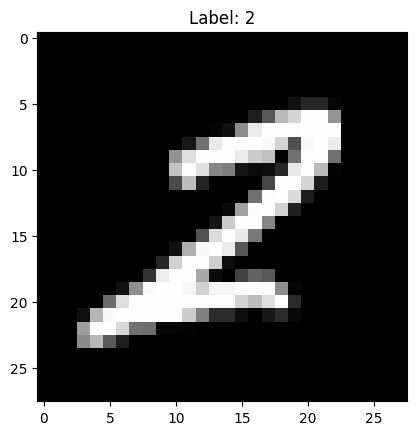

In [6]:
img, label = train_ds[np.random.randint(0, len(train_ds))]
plt.imshow(img[0], cmap="gray")
plt.title(f"Label: {label}")
img.shape, label


In [7]:
# split train ds into train and validation
generator = torch.Generator().manual_seed(42)
train_ds, val_ds = torch.utils.data.random_split(
    train_ds, [0.8, 0.2], generator=generator
)


In [8]:
batch_size = 32


In [9]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False
)
eval_loader = torch.utils.data.DataLoader(
    eval_ds, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False
)


# Model architecture

In [10]:
class DigitClassifier(lt.LightningModule):
    def __init__(self, dropout: float = 0.25, n_classes: int = 10):
        super().__init__()
        self.save_hyperparameters()
        self.dropout = dropout
        self.n_classes = n_classes
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(self.dropout),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(128, self.n_classes),
            # nn.Softmax(dim=-1),
        )
        # self.decorder = nn.Sequential(
        #     nn.Linear(self.embedding_dim, 128),
        #     nn.ReLU(),
        #     nn.Dropout(self.dropout),
        #     nn.Linear(128, 9216),
        #     nn.ReLU(),
        #     nn.Dropout(self.dropout),
        #     nn.Unflatten(1, (64, 14, 14)),
        #     nn.ConvTranspose2d(64, 32, 3, 1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 1, 3, 1),
        #     nn.Sigmoid(),
        # )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

    def get_loss_from_batch(
        self, batch: Tuple[torch.Tensor, torch.Tensor]
    ) -> torch.Tensor:
        x, y = batch
        one_hot_y = torch.nn.functional.one_hot(y, num_classes=self.n_classes).float()
        y_hat = self(x)
        loss = nn.functional.binary_cross_entropy_with_logits(y_hat, one_hot_y)
        return loss

    def training_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        loss = self.get_loss_from_batch(batch)
        self.log("train_loss", loss)
        return loss

    def test_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> None:
        loss = self.get_loss_from_batch(batch)
        self.log("test_loss", loss)

    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> None:
        loss = self.get_loss_from_batch(batch)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = 0):
        x = batch
        logits = self(x)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        return torch.argmax(probs, dim=-1)


# init the autoencoder
classifier = DigitClassifier()


# Training

In [11]:
checkpoint_callback = lt.callbacks.ModelCheckpoint(
    monitor="val_loss", save_top_k=1, mode="min", dirpath=OUTPUT_DIR / "checkpoints"
)
trainer = lt.Trainer(
    default_root_dir=OUTPUT_DIR,
    accelerator="gpu",
    devices="auto",
    max_epochs=50,
    callbacks=[
        # patience of 5 epochs
        lt.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=True),
        # save the best model
        checkpoint_callback,
        # log the metrics to tensorboard
    ],
    logger=lt.loggers.TensorBoardLogger(OUTPUT_DIR / "logs"),
)
trainer.fit(
    model=classifier, train_dataloaders=train_loader, val_dataloaders=val_loader
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /outputs/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.2 M 
---------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.800     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1500/1500 [00:33<00:00, 44.95it/s, v_num=1]      

Metric val_loss improved. New best score: 0.012


Epoch 1: 100%|██████████| 1500/1500 [00:37<00:00, 40.33it/s, v_num=1]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.010


Epoch 2: 100%|██████████| 1500/1500 [00:51<00:00, 29.00it/s, v_num=1]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.009


Epoch 3: 100%|██████████| 1500/1500 [00:51<00:00, 28.97it/s, v_num=1]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 4: 100%|██████████| 1500/1500 [00:51<00:00, 29.09it/s, v_num=1]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 6: 100%|██████████| 1500/1500 [00:50<00:00, 29.59it/s, v_num=1]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 11: 100%|██████████| 1500/1500 [00:36<00:00, 40.84it/s, v_num=1]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.008. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 1500/1500 [00:36<00:00, 40.83it/s, v_num=1]


In [17]:
best_checkpoint = checkpoint_callback.best_model_path
print(
    f"Best checkpoint: {best_checkpoint} with val_loss: {checkpoint_callback.best_model_score}"
)
classifier = DigitClassifier.load_from_checkpoint(best_checkpoint)


Best checkpoint: /outputs/checkpoints/epoch=6-step=10500.ckpt with val_loss: 0.007979213260114193


# Evaluation

In [18]:
result = trainer.test(model=classifier, dataloaders=eval_loader, verbose=True)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 106.61it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.006235434208065271    │
└───────────────────────────┴───────────────────────────┘

# Check on custom image

In [36]:
img6 = transform(Image.open(Path.cwd() / "6.png"))
img7 = transform(Image.open(Path.cwd() / "7.png"))
img2 = transform(Image.open(Path.cwd() / "2.png"))
img9 = transform(Image.open(Path.cwd() / "9.png"))
img4 = transform(Image.open(Path.cwd() / "4.png"))
img5 = transform(Image.open(Path.cwd() / "5.png"))


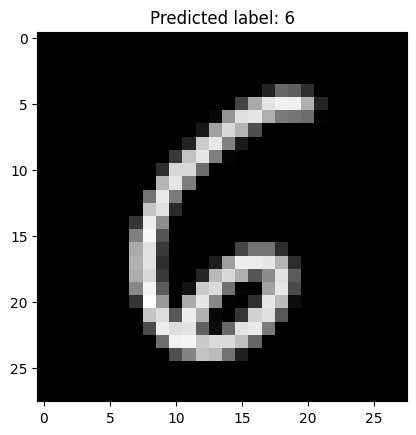

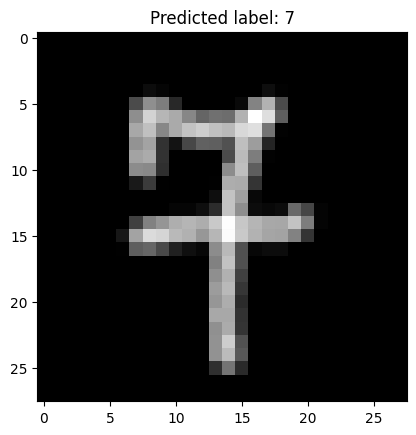

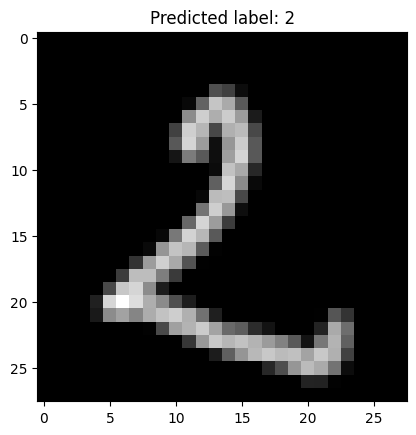

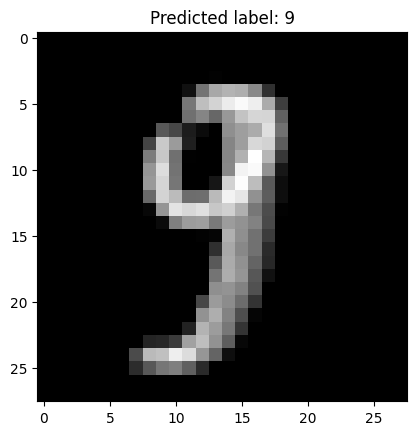

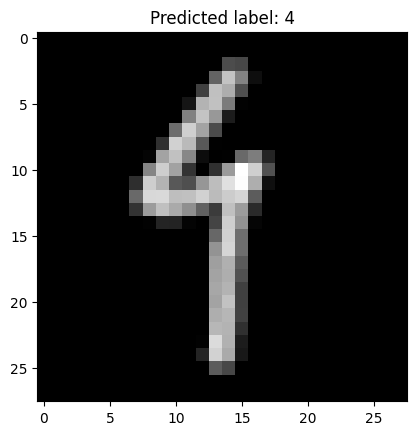

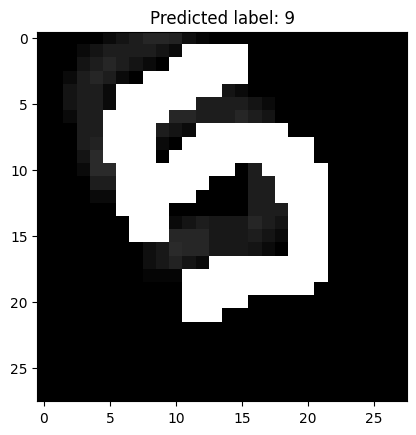

In [37]:
for img in [img6, img7, img2, img9, img4, img5]:
    plt.imshow(img[0], cmap="gray")
    predicted_label = classifier.predict_step(img.unsqueeze(0), 0, 0).item()
    plt.title(f"Predicted label: {predicted_label}")
    plt.show()
